In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the images
image1 = cv2.imread('dataset/im_1.png')
image2 = cv2.imread('dataset/im_2.png')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# print(descriptors2)

In [3]:
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# # Draw first 10 matches
# img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=2)

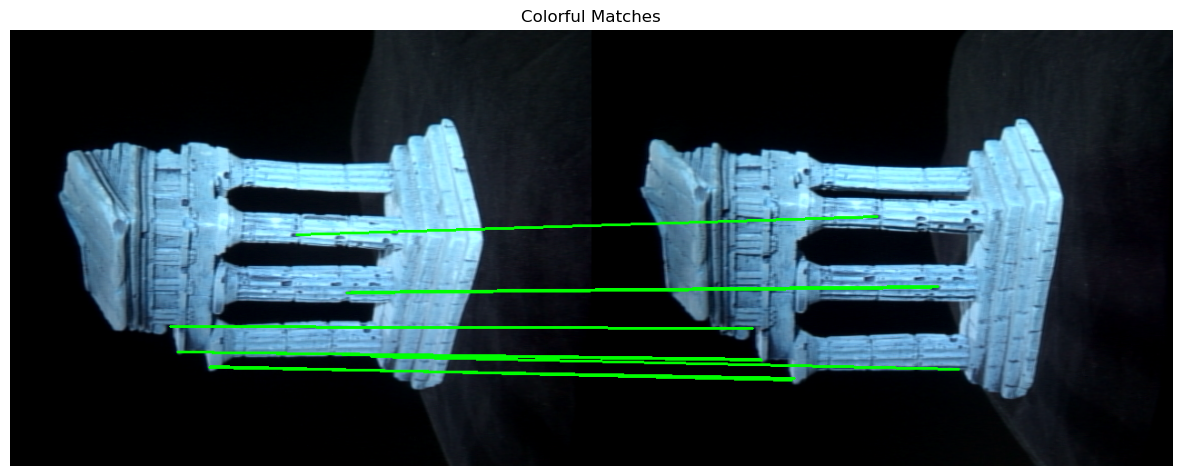

In [4]:
# Function to draw matches with colorful lines
def draw_matches(img1, kp1, img2, kp2, matches, color=None):
    # Create a blank image with adequate space
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]
    new_height = max(height1, height2)
    new_width = width1 + width2
    
    # Create a new output image that concatenates both input images
    output_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    output_img[:height1, :width1, :] = img1
    output_img[:height2, width1:width1+width2, :] = img2
    
    # Draw lines in a specified color
    if color is None:
        color = (255, 0, 0)  # Default color is red
    
    # Go through the first 10 matches (for example)
    for match in matches[:10]:
        # Get the matching keypoints for each of the images
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt
        
        # Draw a line between matches
        cv2.line(output_img, (int(x1), int(y1)), (int(x2) + width1, int(y2)), color, 2)
        
    return output_img

img_matches = draw_matches(image1, keypoints1, image2, keypoints2, matches, color=(0, 255, 0))  # Green lines

# Plot using matplotlib
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
plt.imshow(img_matches)
plt.axis('off')  # Hide the axes
plt.title('Colorful Matches')
plt.show()


In [5]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Camera parameters
focal_length = 26  # in pixel units (assumed conversion based on your camera specs)
baseline = 202.85  # in mm
px = gray1.shape[1] / 2
py = gray1.shape[0] / 2

# Camera matrix
K = np.array([[focal_length, 0, px], [0, focal_length, py], [0, 0, 1]])

# Find Fundamental Matrix
F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_LMEDS)

F = [[-1.91035690e-08, 5.06313909e-07, 8.97337814e-04], [-8.24561412e-07, -2.32987682e-08, 2.26413459e-04], [-8.24574959e-04, -1.59000491e-04, -1.24251378e-02]]

# Calculate Essential Matrix
E = K.T @ F @ K

# Decompose Essential Matrix to get possible [R|t] matrices
_, R, t, _ = cv2.recoverPose(E, points1, points2, K)

# Triangulate Points
projMatrix1 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
projMatrix2 = np.hstack((R, t))

points_3d_hom = cv2.triangulatePoints(projMatrix1, projMatrix2, points1.T, points2.T)

# Convert homogeneous coordinates to 3D
points_3d = points_3d_hom[:3] / points_3d_hom[3]

# Show the 3D points
# print("Reconstructed 3D points:\n", points_3d.T)
import ipyvolume as ipv

# Create a scatter plot
ipv.figure()
ipv.scatter(points_3d[0], points_3d[1], points_3d[2], marker='sphere', color='blue')

# Set labels and show the plot
ipv.xlabel('x')
ipv.ylabel('y')
ipv.zlabel('z')
ipv.show()


/Users/makeshsrinivasan/miniforge3/envs/ASU/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…